In [ ]:
#installs
!pip install -U scikit-learn
!pip install seaborn





In [ ]:
#imports 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.transforms import Compose, Normalize, RandomCrop, RandomHorizontalFlip
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder

import torch.nn.functional as F

import matplotlib.pyplot as plt

import copy
import time

from sklearn.metrics import confusion_matrix
import seaborn as sns




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks/img_classification


/content/gdrive/MyDrive/Colab Notebooks/img_classification


In [ ]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'

torch.cuda.is_available()


True

# Dataset and Dataloaders

## Datasets

In [ ]:
data_dir = './data'

stats = ((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))

augmentation_transform = Compose([
        RandomCrop(32, padding=4, padding_mode='reflect'),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(*stats, inplace=True)
    ])

train_transform = Compose([
        ToTensor(),
        Normalize(*stats, inplace=True)
    ])

val_transform = Compose([
                         ToTensor(),
                         Normalize(*stats)])

train_ds =  datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=train_transform
)

val_ds =  datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=False,
    transform=val_transform
)


batch_sizes = [32, 64, 128]


Files already downloaded and verified


## Dataloaders

### Device Dataloader

In [ ]:
loaders = {}

for batch_size in batch_sizes:

  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

  train_dl = DeviceDataLoader(train_dl, device)
  val_dl = DeviceDataLoader(val_dl, device)

  loaders[batch_size] = [train_dl, val_dl]

In [ ]:
loaders

{32: [<__main__.DeviceDataLoader at 0x7f1a2729bd90>,
 64: [<__main__.DeviceDataLoader at 0x7f1a2729b190>,
 128: [<__main__.DeviceDataLoader at 0x7f1a2729bb10>,
  <__main__.DeviceDataLoader at 0x7f1a2729b7d0>]}

In [ ]:
loaders[32][0].device

'cuda'

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)




# Models

## Base

In [ ]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        imgs, lbls = batch
        out = self(imgs) #Generate predictions
        loss = F.cross_entropy(out, lbls) # Calculate Loss
        return loss

    def validation_step(self, batch):

        imgs, lbls = batch
        out = self(imgs)
        loss = F.cross_entropy(out, lbls)
        acc = accuracy(out, lbls)
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch: {epoch}, last_lr: {result['lrs'][-1]}, train_loss: {result['train_loss']}, val_loss: {result['val_loss']}, val_acc: {result['val_acc']}")


def accuracy(outputs, lbls):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == lbls).item() / len(preds))

## Simple CNN

In [ ]:
class Net(ImageClassificationBase):

    def __init__(self) -> None:
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(), # activation, iterates all elements and if a value is negative, changes to 0 introduces non linearity
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(), # activation, iterates all elements and if a value is negative, changes to 0 introduces non linearity
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(), # activation, iterates all elements and if a value is negative, changes to 0 introduces non linearity
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, xb):
        return self.network(xb)

cnnModel = Net()

In [ ]:
device

'cuda'

In [ ]:
cnnModel.to(device)
cnnModel.cuda

<bound method Module.cuda of Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18

## ResNet

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
  ]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                      nn.Flatten(),
                                      nn.Linear(512, num_classes))
    

  def forward(self, X):

    out = self.conv1(X)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)

    return out


resNetModel = ResNet9(3,10)



In [ ]:
resNetModel.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
resNetModel.__

# Training and Evaluation

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  
    best_acc = [0.0, 0]
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    

    for epoch in range(epochs):

        print(f'Epoch {epoch}/{epochs-1}')
        print('-' * 10)

        # Training Phase 
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            #loss.requires_grad = True
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        epoch_acc = result['val_acc']

        if epoch_acc > best_acc[0]:
          best_acc[0] = epoch_acc
          best_acc[1] = epoch
          torch.save(model, 'best_modelrn9.pt')
        
        print(f"Best Acc: {best_acc[0]} in Epoch no. {best_acc[1]}")

    return history


In [ ]:
history = [evaluate(resNetModel, val_dl)]
history

[{'val_acc': 0.10830078274011612, 'val_loss': 2.304202079772949}]

## Hyperparametres

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
def plot_accuracies(history, filename):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of Epochs')
    plt.savefig(f'acc_{filename}.png')
    plt.show()


def plot_losses(history, filename):
    train_losses = [ x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of Epochs')
    plt.savefig(f'loss_{filename}.png')
    plt.show()


def visualize_model(model, val_loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




Parametres
  -----
  Num Epochs: 10,
  Batch size: 32,
  
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs
Epoch 0/9
----------
Epoch: 0, last_lr: 0.0027981431071167143, train_loss: 0.5248221158981323, val_loss: 0.7899484038352966, val_acc: 0.7352706789970398
Best Acc: 0.7352706789970398 in Epoch no. 0
Epoch 1/9
----------
Epoch: 1, last_lr: 0.007599071373902852, train_loss: 0.7099831104278564, val_loss: 0.8410148024559021, val_acc: 0.7102906107902527
Best Acc: 0.7352706789970398 in Epoch no. 0
Epoch 2/9
----------
Epoch: 2, last_lr: 0.01, train_loss: 0.7752159237861633, val_loss: 0.7497961521148682, val_acc: 0.7427348494529724
Best Acc: 0.7427348494529724 in Epoch no. 2
Epoch 3/9
----------
Epoch: 3, last_lr: 0.009504846320134737, train_loss: 0.7408013343811035, val_loss: 1.0484436750411987, val_acc: 0.6543591022491455
Best Acc: 0.7427348494529724 in Epoch no. 2
Epoch 4/9
----------
Epoch: 4, last_lr: 0.008117456539497631, train_loss: 0.6859750151634216, val_loss: 0.70137

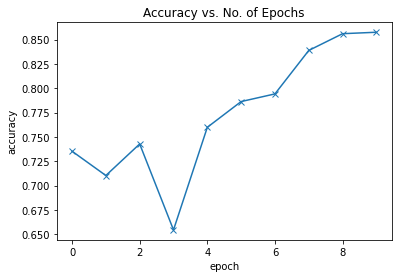

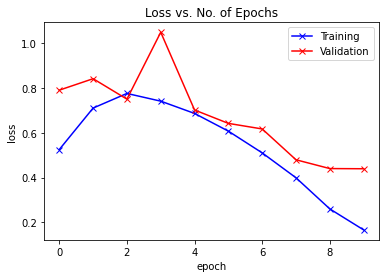

Parametres
  -----
  Num Epochs: 10,
  Batch size: 64,
  
CPU times: user 0 ns, sys: 2 µs, total: 2 µs
Wall time: 6.68 µs
Epoch 0/9
----------
Epoch: 0, last_lr: 0.002796288276714347, train_loss: 0.16991613805294037, val_loss: 0.5712572932243347, val_acc: 0.8270371556282043
Best Acc: 0.8270371556282043 in Epoch no. 0
Epoch 1/9
----------
Epoch: 1, last_lr: 0.007598143420255434, train_loss: 0.3605975806713104, val_loss: 0.6271682977676392, val_acc: 0.796875
Best Acc: 0.8270371556282043 in Epoch no. 0
Epoch 2/9
----------
Epoch: 2, last_lr: 0.01, train_loss: 0.4894494116306305, val_loss: 0.7778607606887817, val_acc: 0.7469343543052673
Best Acc: 0.8270371556282043 in Epoch no. 0
Epoch 3/9
----------
Epoch: 3, last_lr: 0.009504846320134737, train_loss: 0.49041029810905457, val_loss: 0.7395403385162354, val_acc: 0.758999228477478
Best Acc: 0.8270371556282043 in Epoch no. 0
Epoch 4/9
----------
Epoch: 4, last_lr: 0.008117456539497631, train_loss: 0.46883106231689453, val_loss: 0.594101130962

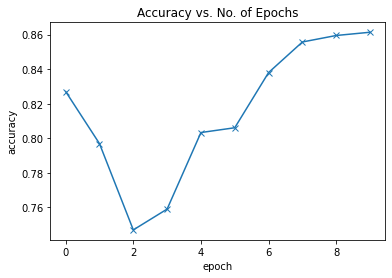

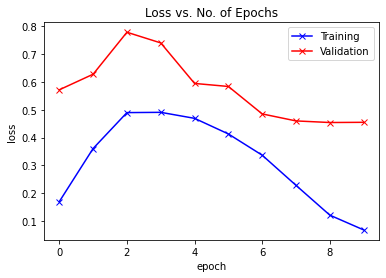

Parametres
  -----
  Num Epochs: 10,
  Batch size: 128,
  
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
Epoch 0/9
----------
Epoch: 0, last_lr: 0.0027925753062899962, train_loss: 0.07193922996520996, val_loss: 0.5758343935012817, val_acc: 0.8379882574081421
Best Acc: 0.8379882574081421 in Epoch no. 0
Epoch 1/9
----------
Epoch: 1, last_lr: 0.007596284777545438, train_loss: 0.25895464420318604, val_loss: 0.8043265342712402, val_acc: 0.7759765386581421
Best Acc: 0.8379882574081421 in Epoch no. 0
Epoch 2/9
----------
Epoch: 2, last_lr: 0.01, train_loss: 0.37148746848106384, val_loss: 1.1762553453445435, val_acc: 0.660937488079071
Best Acc: 0.8379882574081421 in Epoch no. 0
Epoch 3/9
----------
Epoch: 3, last_lr: 0.009504846320134737, train_loss: 0.35620585083961487, val_loss: 0.5625473856925964, val_acc: 0.8145507574081421
Best Acc: 0.8379882574081421 in Epoch no. 0
Epoch 4/9
----------
Epoch: 4, last_lr: 0.008117456539497631, train_loss: 0.32177823781967163, val_lo

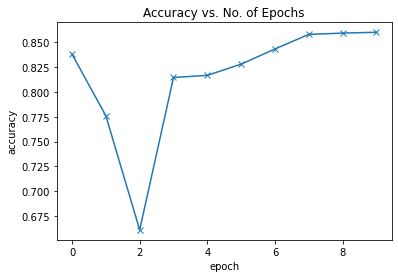

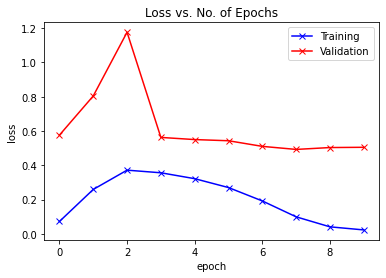

In [ ]:
for key, val in loaders.items():

  print(f"""Parametres
  -----
  Num Epochs: {epochs},
  Batch size: {key},
  """)
  %%time
  history, best_model = fit_one_cycle(epochs, max_lr, resNetModel, val[0], val[1], grad_clip=grad_clip, 
                         weight_decay=weight_decay, opt_func=opt_func)
  
  plot_accuracies(history, f"resNetModel{key}")
  plot_losses(history, f"resNetModel{key}")

  torch.save(best_model, f"resNet{key}Dict.pt")
  



In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, resNetModel, train_dl, val_dl, grad_clip=grad_clip, 
                         weight_decay=weight_decay, opt_func=opt_func)

Epoch: 0, lat_lr: [0.0003999999999999993, 0.0004000269563249007, 0.00040010782499683845, 0.0004002426051075113, 0.0004004312951430937, 0.00040067389298426015, 0.0004009703959061955, 0.0004013208005786417, 0.000401725103065919, 0.0004021832988269861, 0.0004026953827154754, 0.00040326134897976373, 0.000403881191263028, 0.0004045549026033268, 0.0004052824754336645, 0.00040606390158208494, 0.00040689917227177026, 0.0004077882781211191, 0.0004087312091438748, 0.00040972795474922274, 0.00041077850374191156, 0.0004118828443223834, 0.00041304096408690226, 0.0004142528500277014, 0.00041551848853311167, 0.0004168378653877352, 0.00041821096577259083, 0.0004196377742652878, 0.0004211182748401956, 0.0004226524508686245, 0.0004242402851190128, 0.000425881759757123, 0.00042757685634623246, 0.00042932555584735375, 0.0004311278386194429, 0.00043298368441961436, 0.00043489307240337366, 0.00043685598112485485, 0.00043887238853705657, 0.00044094227199209003, 0.0004430656082414306, 0.00044524237343619016, 

# Validation

## Data augmentation

In [ ]:
batch_size_ft = 256

train_ds =  datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=augmentation_transform
)

val_ds =  datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=False,
    transform=val_transform
)

train_dl = DataLoader(train_ds, batch_size_ft, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size_ft*2, num_workers=2, pin_memory=True)
train_dl_ft = DeviceDataLoader(train_dl, device)
val_dl_ft = DeviceDataLoader(val_dl, device)

Files already downloaded and verified


## Prediction

In [ ]:
def predict(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return val_ds.classes[preds[0].item()]


#img, label = val_ds[467]
#plt.imshow(img.permute(1, 2, 0))
#print('Label:', val_ds.classes[label], ', Predicted:', predict(img, resNetFineTunning))





Epoch 0/9
----------
Epoch: 0, last_lr: 0.0027851835584105904, train_loss: 1.2554885149002075, val_loss: 1.082831859588623, val_acc: 0.6149126887321472
Best Acc: 0.6149126887321472 in Epoch no. 0
Epoch 1/9
----------
Epoch: 1, last_lr: 0.007592580310080607, train_loss: 0.9218870997428894, val_loss: 1.8074153661727905, val_acc: 0.5475987792015076
Best Acc: 0.6149126887321472 in Epoch no. 0
Epoch 2/9
----------
Epoch: 2, last_lr: 0.01, train_loss: 0.7938281297683716, val_loss: 1.2265682220458984, val_acc: 0.6216853857040405
Best Acc: 0.6216853857040405 in Epoch no. 2
Epoch 3/9
----------
Epoch: 3, last_lr: 0.009504846320134737, train_loss: 0.6052901148796082, val_loss: 1.1297537088394165, val_acc: 0.6879020929336548
Best Acc: 0.6879020929336548 in Epoch no. 3
Epoch 4/9
----------
Epoch: 4, last_lr: 0.008117456539497631, train_loss: 0.4544855058193207, val_loss: 0.5621666312217712, val_acc: 0.8212717771530151
Best Acc: 0.8212717771530151 in Epoch no. 4
Epoch 5/9
----------
Epoch: 5, last_

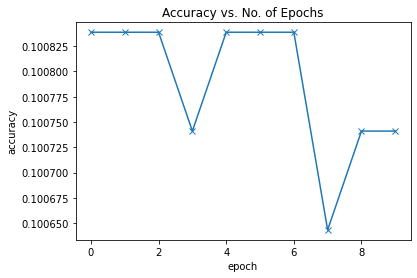

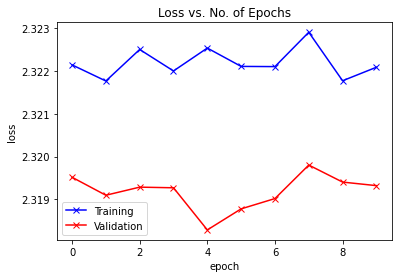

array([[938,   3,  15,   7,   1,   1,   1,   3,  21,  10],
       [  6, 977,   0,   1,   0,   0,   0,   0,   3,  13],
       [ 25,   0, 877,  23,  23,  21,  21,   6,   2,   2],
       [  8,   2,  19, 800,  19,  93,  27,  14,   6,  12],
       [  6,   1,  17,  20, 919,  16,   9,  10,   2,   0],
       [  4,   0,  11,  66,  19, 879,   6,  13,   0,   2],
       [  4,   0,  16,  19,   6,   3, 946,   4,   1,   1],
       [  4,   0,   7,  16,  13,  17,   3, 938,   0,   2],
       [ 35,   8,   2,   1,   0,   0,   2,   1, 943,   8],
       [  6,  28,   1,   1,   0,   1,   0,   1,  10, 952]])

In [ ]:
resNet9 = ResNet9(3, 10)
resNet9.to(device)



history = fit_one_cycle(epochs, max_lr, resNet9, train_dl_ft, val_dl_ft, grad_clip=grad_clip, 
                         opt_func=opt_func)

plot_accuracies(history_ft, 'resNet_best')
plot_losses(history_ft, 'resNest_best')

y = []
y_pred = []

for img, lbl in val_ds:
  y.append(val_ds.classes[lbl])
  y_pred.append(predict(img, resNet9))

confusion_matrix(y, y_pred, labels=val_ds.classes)




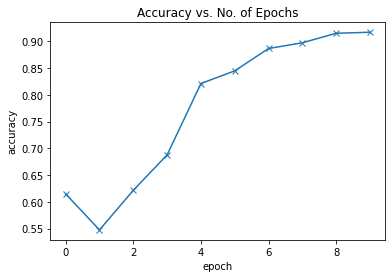

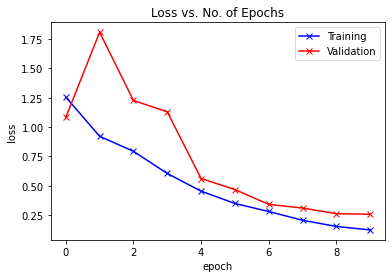

In [ ]:
plot_accuracies(history, 'resNet_best')
plot_losses(history, 'resNest_best')

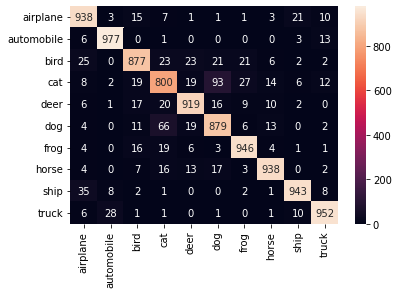

In [ ]:
sns.heatmap(confusion_matrix(y, y_pred, labels=val_ds.classes), annot=True, xticklabels=val_ds.classes, yticklabels=val_ds.classes, fmt='g')

# Transfer Learning

## Fixed Feature Extractor

### tf training function

In [ ]:
dataloaders = {
    'train': train_dl_ft,
    'val': val_dl_ft
}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    accs = []
    loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            accs.append(epoch_acc)
            accs.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return accs, loss

<bound method Module.cuda of ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
for param in resNet9.parameters():
    param.requires_grad = False

resNet9.classifier = nn.Linear(512, 10)

criterion = nn.CrossEntropyLoss().
optimizer_conv = optim.SGD(resNet9.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


accs, loss = train_model(resNet9, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)


Epoch 0/19
----------


RuntimeError: ignored